# GSDS Final Project
## Christian Turner
### May 27th, 2024

In [536]:
# General Imports
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np


from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import os

# Graphics
from pysal.viz import splot
from splot.esda import plot_moran
import contextily as cx

#plot visualizations in line
%matplotlib inline 

# Analysis
from pysal.explore import esda
from pysal.lib import weights
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights


## frmo class imports, may not need all

from splot.libpysal import plot_spatial_weights
from pysal.lib import weights
#from sklearn import cluster
#from sklearn.preprocessing import robust_scale

sns.set_theme()

#stop pandas from truncating column output
#pd.reset_option('display.max_colwidth')


# test imports. soemthing above wasnt working
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights
#import matplotlib.pyplot as plt

# Load the Datasets

In [537]:
# Income Data
INCOME_DATA = gpd.read_file("/Users/christiancoleturner/Desktop/GSDS Project/LA INCOME DATA/Median_Income_and_AMI_(census_tract)")

# Green Data
GREEN_DATA = gpd.read_file("/Users/christiancoleturner/Desktop/GSDS Project/Countywide_Parks_and_Open_Space_(Public_-_Hosted)")

In [538]:
# view the data
INCOME_DATA

tract  med_hh_inc  med_hh_i_1             ami_catego below_med_  \
0     06037199700     38892.0        1204        Very Low Income        Yes   
1     06037199801     41027.0         903        Very Low Income        Yes   
2     06037199802     42500.0         612        Very Low Income        Yes   
3     06037199900     37232.0         845        Very Low Income        Yes   
4     06037201110     65000.0         782             Low Income        Yes   
...           ...         ...         ...                    ...        ...   
2490  06037554516    126450.0        1215  Above Moderate Income         No   
2491  06037554517    107672.0        1352  Above Moderate Income         No   
2492  06037554518    104439.0        1558  Above Moderate Income         No   
2493  06037554519    131012.0        1216  Above Moderate Income         No   
2494  06037554521     90280.0        1863             Low Income         No   

     below_60pc below_mode    sup_dist                               csa  \
0           Yes        Yes  District 1  Los Angeles - Wholesale District   
1           Yes        Yes  District 1     Los Angeles - Lincoln Heights   
2           Yes        Yes  District 1     Los Angeles - Lincoln Heights   
3           Yes        Yes  District 1     Los Angeles - Lincoln Heights   
4            No        Yes  District 1           Los Angeles - El Sereno   
...         ...        ...         ...                               ...   
2490         No         No  District 4                  City of Cerritos   
2491         No         No  District 4                  City of Cerritos   
2492         No         No  District 4                  City of Cerritos   
2493         No         No  District 4                  City of Cerritos   
2494         No        Yes  District 4                  City of Cerritos   

                spa  ESRI_OID    Shape__Are    Shape__Len  \
0     SPA 4 - Metro      2347  1.041050e+07  13808.463241   
1     SPA 4 - Metro      2348  3.724107e+06   9459.391827   
2     SPA 4 - Metro      2349  3.296129e+06   8868.744225   
3     SPA 4 - Metro      2350  4.782361e+06  10141.728022   
4     SPA 4 - Metro      2351  1.099246e+07  15893.383636   
...             ...       ...           ...           ...   
2490   SPA 7 - East      4837  1.555650e+07  21274.227408   
2491   SPA 7 - East      4838  1.421767e+07  15905.089174   
2492   SPA 7 - East      4839  1.938903e+07  21218.412991   
2493   SPA 7 - East      4840  1.866694e+07  19500.866806   
2494   SPA 7 - East      4841  5.352220e+07  37625.839752   

                                               geometry  
0     POLYGON ((-118.22672 34.06242, -118.22453 34.0...  
1     POLYGON ((-118.21559 34.07186, -118.21169 34.0...  
2     POLYGON ((-118.21563 34.07365, -118.21309 34.0...  
3     POLYGON ((-118.21528 34.06349, -118.21547 34.0...  
4     POLYGON ((-118.18182 34.09277, -118.18039 34.0...  
...                                                 ...  
2490  POLYGON ((-118.07225 33.85452, -118.07047 33.8...  
2491  POLYGON ((-118.06374 33.86586, -118.05352 33.8...  
2492  POLYGON ((-118.04646 33.87326, -118.03776 33.8...  
2493  POLYGON ((-118.06362 33.85858, -118.05495 33.8...  
2494  POLYGON ((-118.10858 33.88694, -118.10828 33.8...  

[2495 rows x 14 columns]

In [539]:
#check crs for both
INCOME_DATA.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [540]:
GREEN_DATA.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [541]:
# Change EPSG to Local - switches to local units 
GREEN_DATA = GREEN_DATA.to_crs(epsg=2229)
INCOME_DATA = INCOME_DATA.to_crs(epsg=2229)

In [542]:
# Inspect Income data 
INCOME_DATA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tract       2495 non-null   object  
 1   med_hh_inc  2458 non-null   float64 
 2   med_hh_i_1  2495 non-null   int64   
 3   ami_catego  2458 non-null   object  
 4   below_med_  2458 non-null   object  
 5   below_60pc  2458 non-null   object  
 6   below_mode  2458 non-null   object  
 7   sup_dist    2495 non-null   object  
 8   csa         2495 non-null   object  
 9   spa         2495 non-null   object  
 10  ESRI_OID    2495 non-null   int64   
 11  Shape__Are  2495 non-null   float64 
 12  Shape__Len  2495 non-null   float64 
 13  geometry    2495 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(8)
memory usage: 273.0+ KB


In [543]:
# Drop unneeded columns
INCOME_DATA = INCOME_DATA.drop(columns = ['below_med_', 'below_60pc','ami_catego', 'below_mode', 'sup_dist','csa', 'spa', 'ESRI_OID', 'Shape__Len' ])

In [544]:
INCOME_DATA

tract  med_hh_inc  med_hh_i_1    Shape__Are  \
0     06037199700     38892.0        1204  1.041050e+07   
1     06037199801     41027.0         903  3.724107e+06   
2     06037199802     42500.0         612  3.296129e+06   
3     06037199900     37232.0         845  4.782361e+06   
4     06037201110     65000.0         782  1.099246e+07   
...           ...         ...         ...           ...   
2490  06037554516    126450.0        1215  1.555650e+07   
2491  06037554517    107672.0        1352  1.421767e+07   
2492  06037554518    104439.0        1558  1.938903e+07   
2493  06037554519    131012.0        1216  1.866694e+07   
2494  06037554521     90280.0        1863  5.352220e+07   

                                               geometry  
0     POLYGON ((6492999.376 1845173.955, 6493667.800...  
1     POLYGON ((6496375.924 1848603.024, 6497557.044...  
2     POLYGON ((6496367.023 1849253.368, 6497136.855...  
3     POLYGON ((6496464.188 1845555.732, 6496410.410...  
4     POLYGON ((6506617.527 1856193.796, 6507052.418...  
...                                                 ...  
2490  POLYGON ((6539728.589 1769445.413, 6540269.373...  
2491  POLYGON ((6542315.384 1773572.029, 6545420.181...  
2492  POLYGON ((6547562.004 1776260.739, 6550203.286...  
2493  POLYGON ((6542350.442 1770923.725, 6544981.870...  
2494  POLYGON ((6528712.656 1781255.943, 6528802.495...  

[2495 rows x 5 columns]

## INSPECT THE INCOME DATA AND CLEAN

In [545]:
# Find if we have null values for median household income
INCOME_DATA[INCOME_DATA['med_hh_inc'].isnull()];

In [546]:
# Drop rows with null values
INCOME_DATA.dropna(subset=['med_hh_inc'], inplace = True);

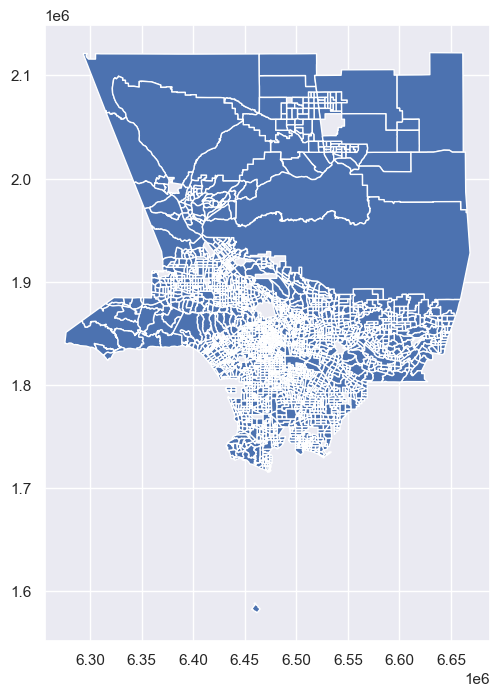

In [547]:
#plot the map of income data
%matplotlib inline
f, ax = plt.subplots(1, figsize=(8,8))
INCOME_DATA.plot(ax=ax)
# Display
plt.show()

In [548]:
#INCOME_DATA.explore()

For the purposes on this project, I'm interested in the contiguous Los Angeles Metro area.
Therefore I will remove the 2 outlier islands, manually by tract number.

Further, these islands could present an issue when computing spatial weight matrices.

In [549]:
INCOME_DATA = INCOME_DATA[INCOME_DATA['tract'] != '06037599100']
INCOME_DATA = INCOME_DATA[INCOME_DATA['tract'] != '06037599000']


In [550]:
#index on the local authority's ID
INCOME_DATA = INCOME_DATA.set_index("tract", drop=False)
# Display summary
INCOME_DATA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2457 entries, 06037199700 to 06037554521
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tract       2457 non-null   object  
 1   med_hh_inc  2457 non-null   float64 
 2   med_hh_i_1  2457 non-null   int64   
 3   Shape__Are  2457 non-null   float64 
 4   geometry    2457 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 115.2+ KB


To get an idea of income distribution, we make a choropleth map for median house hold income, column "med_hh_inc" using quintiles


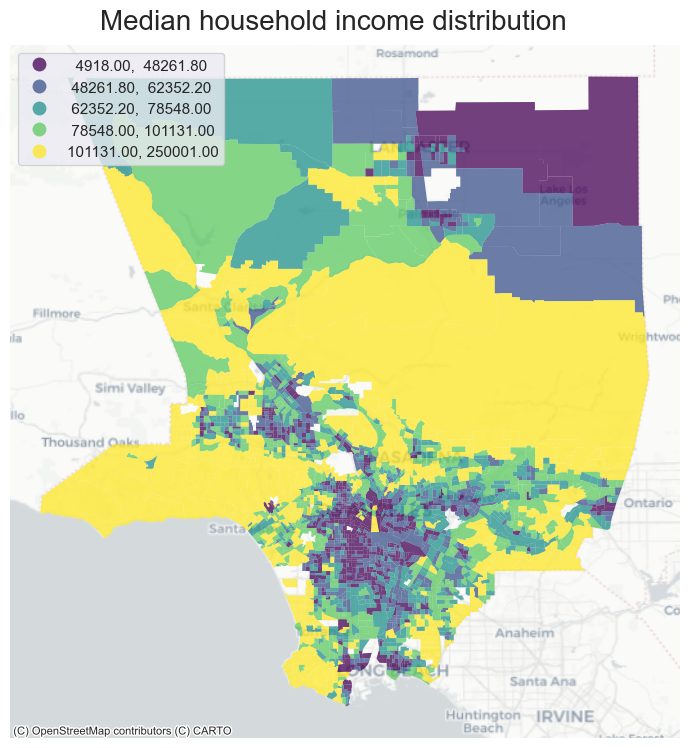

In [551]:
f, ax = plt.subplots(1, figsize=(9, 9))
INCOME_DATA.plot(
    column="med_hh_inc",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=INCOME_DATA.crs,
    source=cx.providers.CartoDB.Positron
)
f.suptitle('Median household income distribution', size=20, y=0.92)

ax.set_axis_off()

# Save the figure
output_filename = "income_map.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
# plt.close(f)  # Close the figure to free up memory

# Spatial weights matrix

Code for spatial autocorrelation was found in course materials.

In [553]:
# Create the spatial weights matrix
w = weights.Queen.from_dataframe(INCOME_DATA, idVariable="tract")

/var/folders/bl/13rctt8d7y9c04ldf_343xjr0000gn/T/ipykernel_42014/2985077054.py:2: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(INCOME_DATA, idVariable="tract")
/Users/christiancoleturner/Library/Python/3.9/lib/python/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [554]:
# Check neighbors
w["06037199700"]

{'06037199001': 1.0,
 '06037206020': 1.0,
 '06037199801': 1.0,
 '06037206010': 1.0,
 '06037199201': 1.0,
 '06037199900': 1.0,
 '06037199002': 1.0,
 '06037203500': 1.0,
 '06037980010': 1.0,
 '06037199802': 1.0}

In [555]:
#check for islands
w.islands

[]

In [556]:
w.transform = 'R'

In [557]:
# Check that row weights add to one.
w["06037199700"]

{'06037199001': 0.1,
 '06037206020': 0.1,
 '06037199801': 0.1,
 '06037206010': 0.1,
 '06037199201': 0.1,
 '06037199900': 0.1,
 '06037199002': 0.1,
 '06037203500': 0.1,
 '06037980010': 0.1,
 '06037199802': 0.1}

### Visualize spatial weights

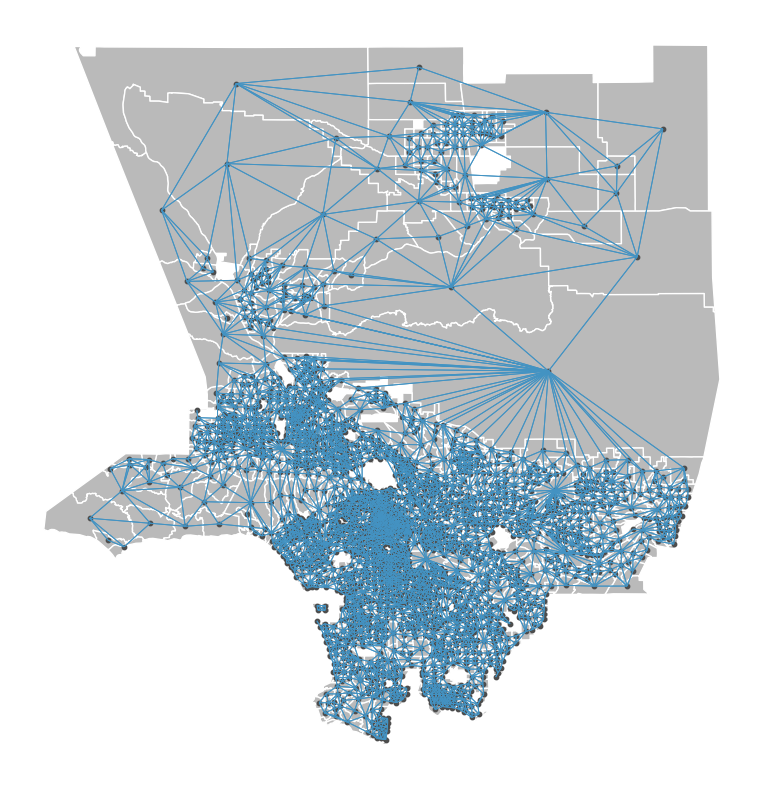

In [558]:
plot_spatial_weights(w, INCOME_DATA.to_crs(epsg=2229), indexed_on="tract"); # Use California grid section 5, 2229

# ANALYSIS

## Spatial Lag

In [559]:
INCOME_DATA['w_med_hh_inc'] = weights.lag_spatial(w, INCOME_DATA['med_hh_inc']) # we pass the weights object and the column with values to base the spatial lag on

In [560]:
INCOME_DATA[['tract', 'med_hh_inc', 'w_med_hh_inc']].head()

tract  med_hh_inc  w_med_hh_inc
tract                                             
06037199700  06037199700     38892.0  50484.400000
06037199801  06037199801     41027.0  38093.500000
06037199802  06037199802     42500.0  45232.833333
06037199900  06037199900     37232.0  39088.600000
06037201110  06037201110     65000.0  89542.666667

In [561]:
w.neighbors['06037199700']

['06037199001',
 '06037206020',
 '06037199801',
 '06037206010',
 '06037199201',
 '06037199900',
 '06037199002',
 '06037203500',
 '06037980010',
 '06037199802']

In [562]:
# Check the values for neighbors to verify
neig = INCOME_DATA.loc[w.neighbors['06037199700'], 'med_hh_inc']
print(neig)
print('mean:',neig.mean())

tract
06037199001     50679.0
06037206020    105972.0
06037199801     41027.0
06037206010     41395.0
06037199201     51250.0
06037199900     37232.0
06037199002     62390.0
06037203500     40524.0
06037980010     31875.0
06037199802     42500.0
Name: med_hh_inc, dtype: float64
mean: 50484.4


## Standardize our data 

In [563]:
INCOME_DATA['med_hh_inc_std'] = (
    INCOME_DATA['med_hh_inc'] - INCOME_DATA['med_hh_inc'].mean()
) / INCOME_DATA['med_hh_inc'].std()

In [564]:
# Create spatial lag of standardized values
INCOME_DATA['w_med_hh_inc_std'] = weights.lag_spatial(w, INCOME_DATA['med_hh_inc_std'])

In [565]:
INCOME_DATA[['tract', 'med_hh_inc', 'w_med_hh_inc', 'med_hh_inc_std', 'w_med_hh_inc_std']].head()

tract  med_hh_inc  w_med_hh_inc  med_hh_inc_std  \
tract                                                                
06037199700  06037199700     38892.0  50484.400000       -1.067600   
06037199801  06037199801     41027.0  38093.500000       -1.007549   
06037199802  06037199802     42500.0  45232.833333       -0.966119   
06037199900  06037199900     37232.0  39088.600000       -1.114290   
06037201110  06037201110     65000.0  89542.666667       -0.333267   

             w_med_hh_inc_std  
tract                          
06037199700         -0.741544  
06037199801         -1.090059  
06037199802         -0.889253  
06037199900         -1.062070  
06037201110          0.357038

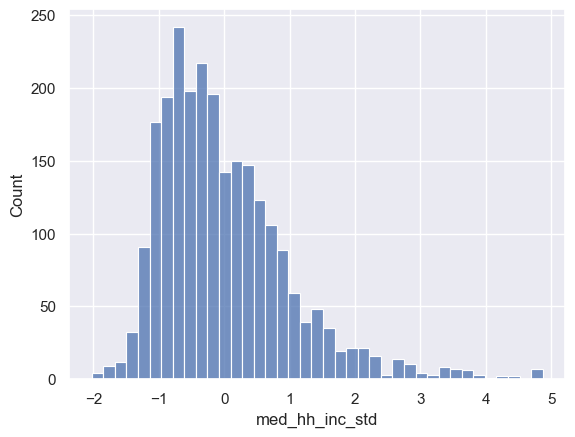

In [566]:
sns.histplot(INCOME_DATA.med_hh_inc_std);

In [567]:
INCOME_DATA['med_hh_inc_std'].describe()

count    2.457000e+03
mean    -8.675735e-17
std      1.000000e+00
min     -2.023178e+00
25%     -7.230755e-01
50%     -2.014089e-01
75%      4.972312e-01
max      4.870208e+00
Name: med_hh_inc_std, dtype: float64

## Global Spatial Autocorrelation

### Moran Plot

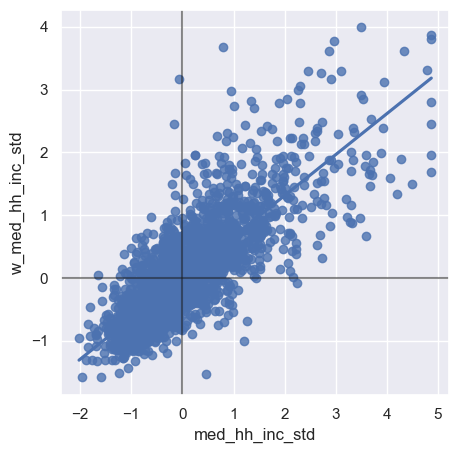

In [568]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='med_hh_inc_std', y='w_med_hh_inc_std', data=INCOME_DATA, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

### Moran's I

In [569]:
mi = esda.Moran(INCOME_DATA['med_hh_inc'], w)

In [570]:
mi.I

0.6518212443436213

In [571]:
mi.p_sim

0.001

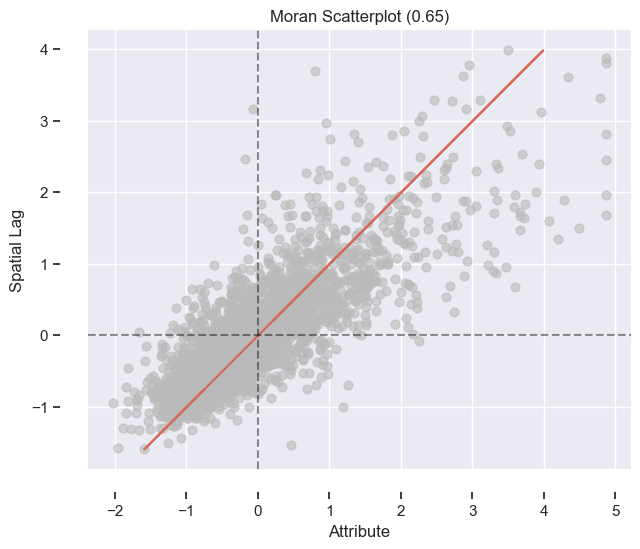

In [572]:
moran_scatterplot(mi);

/Users/christiancoleturner/Library/Python/3.9/lib/python/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


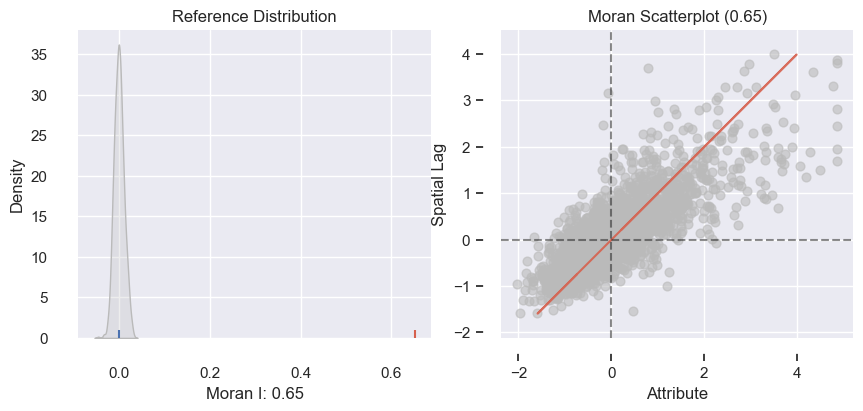

In [573]:
plot_moran(mi);

## Local Spatial Autocorrelation

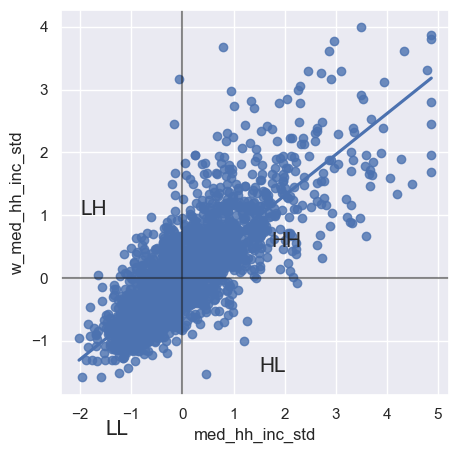

In [574]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='med_hh_inc_std', y='w_med_hh_inc_std', data=INCOME_DATA, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=15)
plt.text(1.5, -1.5, "HL", fontsize=15)
plt.text(-2, 1, "LH", fontsize=15)
plt.text(-1.5, -2.5, "LL", fontsize=15)
# Display
plt.show()

In [575]:
INCOME_DATA['w_med_hh_inc_std'].describe()

count    2457.000000
mean        0.010268
std         0.807270
min        -1.584307
25%        -0.615102
50%        -0.124840
75%         0.438638
max         3.991233
Name: w_med_hh_inc_std, dtype: float64

### LISA

In [576]:
lisa = esda.Moran_Local(INCOME_DATA['med_hh_inc'], w)


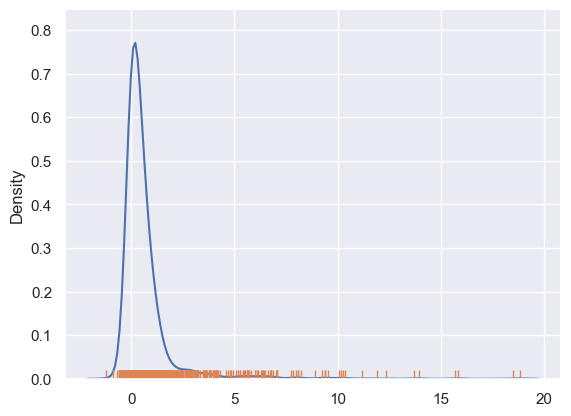

In [577]:
# Draw KDE (kernal density estimation) line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

In [578]:
lisa.Is.sum()

1600.872976107934

In [579]:
mi.I*len(INCOME_DATA)

1601.5247973522776

#### STATISTICAL SIGNIFICANCE 

In [580]:
# Break observations into significant or not
INCOME_DATA['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
INCOME_DATA['quadrant'] = lisa.q

In [581]:
INCOME_DATA['quadrant']

tract
06037199700    3
06037199801    3
06037199802    3
06037199900    3
06037201110    2
              ..
06037554516    1
06037554517    1
06037554518    1
06037554519    1
06037554521    1
Name: quadrant, Length: 2457, dtype: int64

In [582]:
INCOME_DATA['significant'].head()

tract
06037199700     True
06037199801     True
06037199802     True
06037199900     True
06037201110    False
Name: significant, dtype: bool

In [583]:
lisa.p_sim[:5]

array([0.002, 0.002, 0.003, 0.001, 0.198])

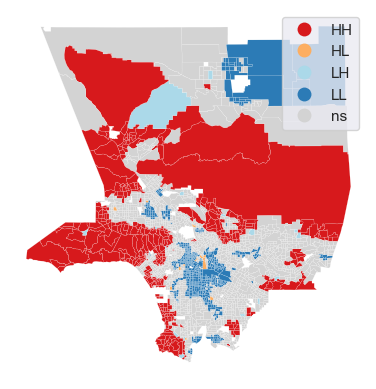

In [584]:
lisa_cluster(lisa, INCOME_DATA, p=0.05); # the vaue for p changes the significance threshold used in the plot

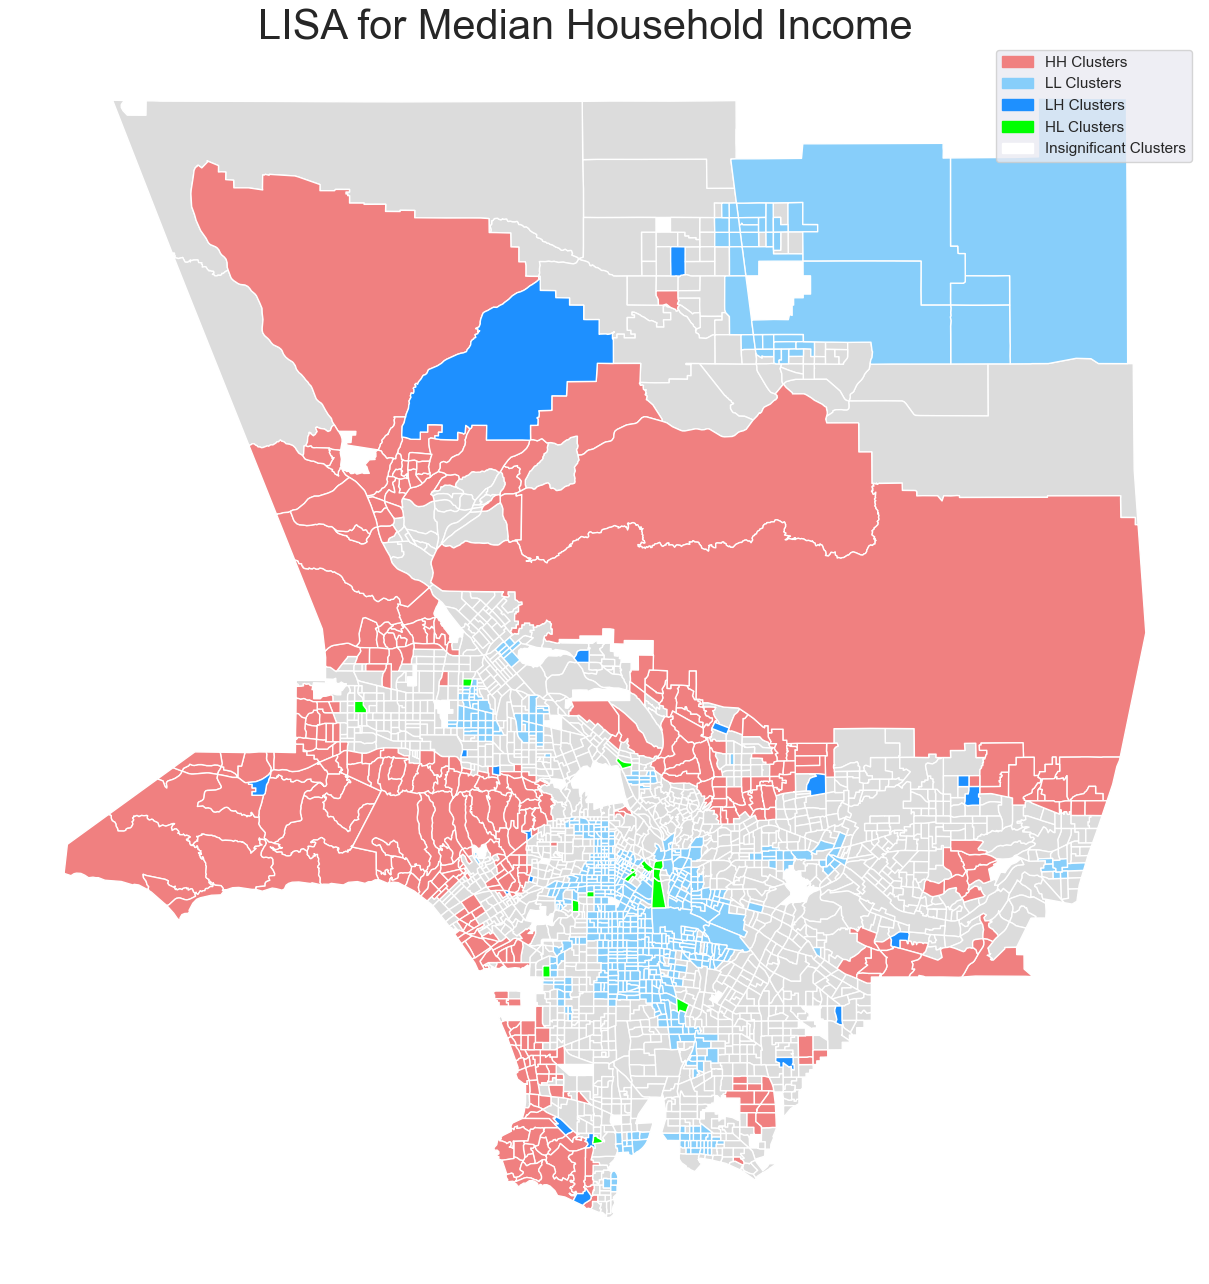

In [585]:
import matplotlib.patches as mpatches

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(16, 16))
# Plot insignificant clusters
ns = INCOME_DATA.loc[INCOME_DATA['significant']==False, 'geometry']
ns.plot(ax=ax, color='gainsboro', edgecolor = None)
# Plot HH clusters
hh = INCOME_DATA.loc[(INCOME_DATA['quadrant']==1) & (INCOME_DATA['significant']==True), 'geometry']
hh.plot(ax=ax, color='lightcoral', edgecolor = None)
# Plot LL clusters
ll = INCOME_DATA.loc[(INCOME_DATA['quadrant']==3) & (INCOME_DATA['significant']==True), 'geometry']
ll.plot(ax=ax, color='lightskyblue', edgecolor = None)
# Plot LH clusters
lh = INCOME_DATA.loc[(INCOME_DATA['quadrant']==2) & (INCOME_DATA['significant']==True), 'geometry']
lh.plot(ax=ax, color='dodgerblue', edgecolor = None)
# Plot HL clusters
hl = INCOME_DATA.loc[(INCOME_DATA['quadrant']==4) & (INCOME_DATA['significant']==True), 'geometry']
hl.plot(ax=ax, color='lime', edgecolor = None)
# Style and draw
f.suptitle('LISA for Median Household Income', size=30, y=0.9)
f.set_facecolor('white')  # Change the figure face color to white
#f.set_facecolor('0.85')
ax.set_axis_off()



# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='lightcoral', label='HH Clusters'),
    mpatches.Patch(color='lightskyblue', label='LL Clusters'),
    mpatches.Patch(color='dodgerblue', label='LH Clusters'),
    mpatches.Patch(color='lime', label='HL Clusters'),
    mpatches.Patch(color='white', label='Insignificant Clusters')
]
plt.legend(handles=legend_patches, loc='upper right')

plt.savefig('LISA_for_Median_Household_Income.png', dpi=300, bbox_inches='tight')

plt.show()

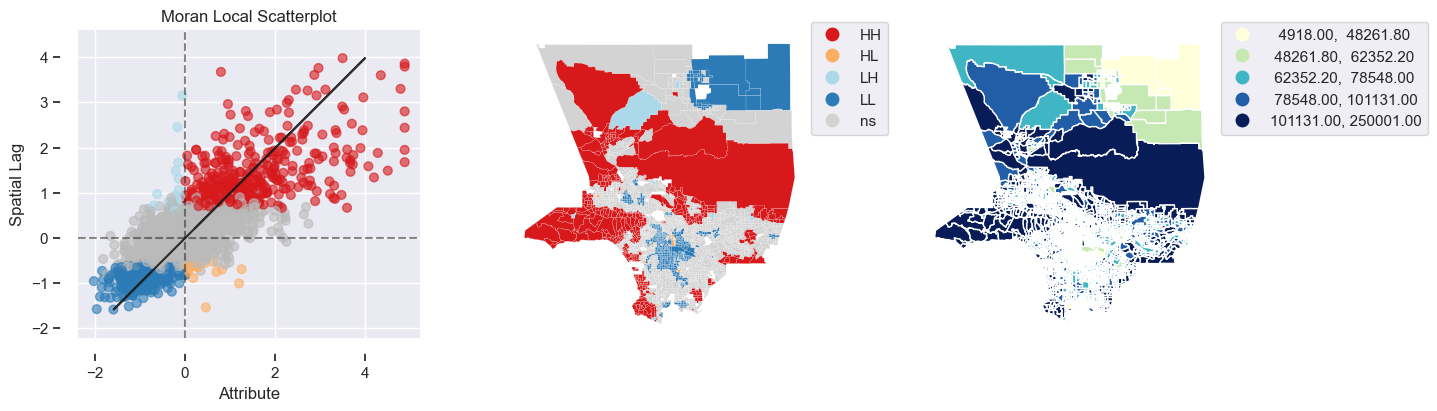

In [586]:
plot_local_autocorrelation(lisa, INCOME_DATA, 'med_hh_inc');

# GREEN DATA

#### Preprocess the Green Data

In [587]:
# Find how many parks are in each access category
GREEN_DATA['ACCESS_TYP'].value_counts()

    # Restricted Acccess seem to all be schools.


ACCESS_TYP
Open Access          2403
Unknown Access        218
No Public Access      196
Restricted Access     193
Restricted Use          2
Name: count, dtype: int64

In [588]:
GREEN_DATA.loc[GREEN_DATA['ACCESS_TYP'] == 'Restricted Access']; # Find areas with restricted access

In [589]:
GREEN_DATA[['CENTER_LON', 'CENTER_LAT']].iloc[2777]; # Locate lat/lon of specific rows

In [590]:
# Drop UGSs without public access or unknown access
GREEN_DATA = GREEN_DATA.drop(GREEN_DATA[GREEN_DATA['ACCESS_TYP'] == 'No Public Access'].index)
GREEN_DATA = GREEN_DATA.drop(GREEN_DATA[GREEN_DATA['ACCESS_TYP'] == 'Unknown Access'].index)

#drop unneeded columns
GREEN_DATA.drop(GREEN_DATA.columns.difference(["LMS_ID","PARK_NAME", "ACCESS_TYP", "RPT_ACRES", "GIS_ACRES", "CENTER_LAT", "CENTER_LON", "CITY", "Shape_Length", "Shape_Area", "geometry"]), axis = 1, inplace = True)

#drop all Catalina Island Values using latitude boundary.
drop_index = GREEN_DATA[GREEN_DATA['CENTER_LAT'] < 33.6].index
GREEN_DATA = GREEN_DATA.drop(drop_index)
len(GREEN_DATA)


2590

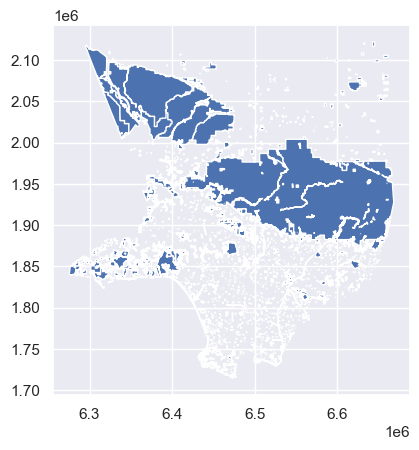

In [591]:
%matplotlib inline
GREEN_DATA.plot();

In [592]:
GREEN_DATA

LMS_ID                                    PARK_NAME  \
0       23603.0                               El Barrio Park   
1           NaN                               El Dorado Park   
2     3000015.0                         Atlantic Avenue Park   
3       22715.0                            El Escorpion Park   
4       22860.0         El Marino Park/ El Marino Elementary   
...         ...                                          ...   
3007  3000052.0  Eaton Canyon Natural Area and Nature Center   
3008  3000074.0       Earvin "Magic" Johnson Recreation Area   
3009  3000071.0                               Hollywood Bowl   
3010  3000064.0                William S. Hart Regional Park   
3011        NaN     Greater Whittier Regional Aquatic Center   

             ACCESS_TYP   RPT_ACRES   GIS_ACRES  CENTER_LAT  CENTER_LON  \
0           Open Access    2.093000    2.092992   34.097081 -117.704423   
1           Open Access    5.144000    5.143217   34.691578 -118.122109   
2           Open Access    1.960000    1.959610   34.025304 -118.155201   
3           Open Access   66.914000   66.338029   34.196742 -118.664169   
4           Open Access    3.200000    1.650439   33.992516 -118.399233   
...                 ...         ...         ...         ...         ...   
3007        Open Access  219.087769  219.087769   34.183308 -118.096038   
3008        Open Access  120.660000  120.660543   33.919756 -118.260350   
3009        Open Access   77.430000   77.428979   34.112703 -118.339429   
3010        Open Access  155.869048  155.869048   34.371577 -118.526456   
3011  Restricted Access    2.347900    2.347900   33.972877 -118.078681   

             CITY                                           geometry  
0       Claremont  POLYGON ((6651332.852 1857986.230, 6651216.192...  
1       Lancaster  POLYGON ((6524837.629 2074512.156, 6524837.893...  
2     Los Angeles  POLYGON ((6514577.703 1831816.732, 6514578.308...  
3      West Hills  POLYGON ((6359939.963 1895401.522, 6359937.651...  
4     Culver City  POLYGON ((6440692.476 1819788.023, 6440689.140...  
...           ...                                                ...  
3007     Pasadena  MULTIPOLYGON (((6532681.781 1890122.542, 65326...  
3008  Los Angeles  MULTIPOLYGON (((6483949.270 1792096.751, 64838...  
3009  Los Angeles  MULTIPOLYGON (((6459916.481 1861858.530, 64598...  
3010      Newhall  MULTIPOLYGON (((6403118.590 1959612.174, 64031...  
3011     Whittier  POLYGON ((6537752.157 1812746.361, 6537907.967...  

[2590 rows x 9 columns]

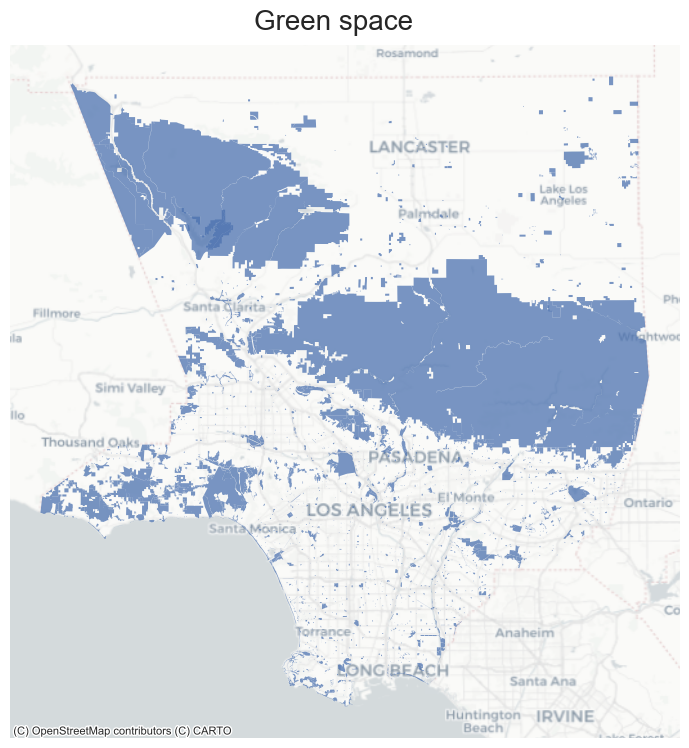

In [593]:
f, ax = plt.subplots(1, figsize=(9, 9))
GREEN_DATA.plot(
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=INCOME_DATA.crs,
    source=cx.providers.CartoDB.Positron
)
f.suptitle('Green space', size=20, y=0.92)

ax.set_axis_off()

# Save the figure
output_filename = "Green Space.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

### Find Centroids, then find the  distance between the centroids of the census tracts and the nearest green space

In [594]:
# Add a column for centroids of parks for ease of analysis
GREEN_DATA['CENTROID_GREEN'] = GREEN_DATA.geometry.centroid
GREEN_DATA_CENT = GREEN_DATA['CENTROID_GREEN']

INCOME_DATA_CENTROID = INCOME_DATA.geometry.centroid
INCOME_DATA['min_dist'] = INCOME_DATA_CENTROID.geometry.apply(lambda x: GREEN_DATA_CENT.distance(x).min())


#### Plot the minimum distances

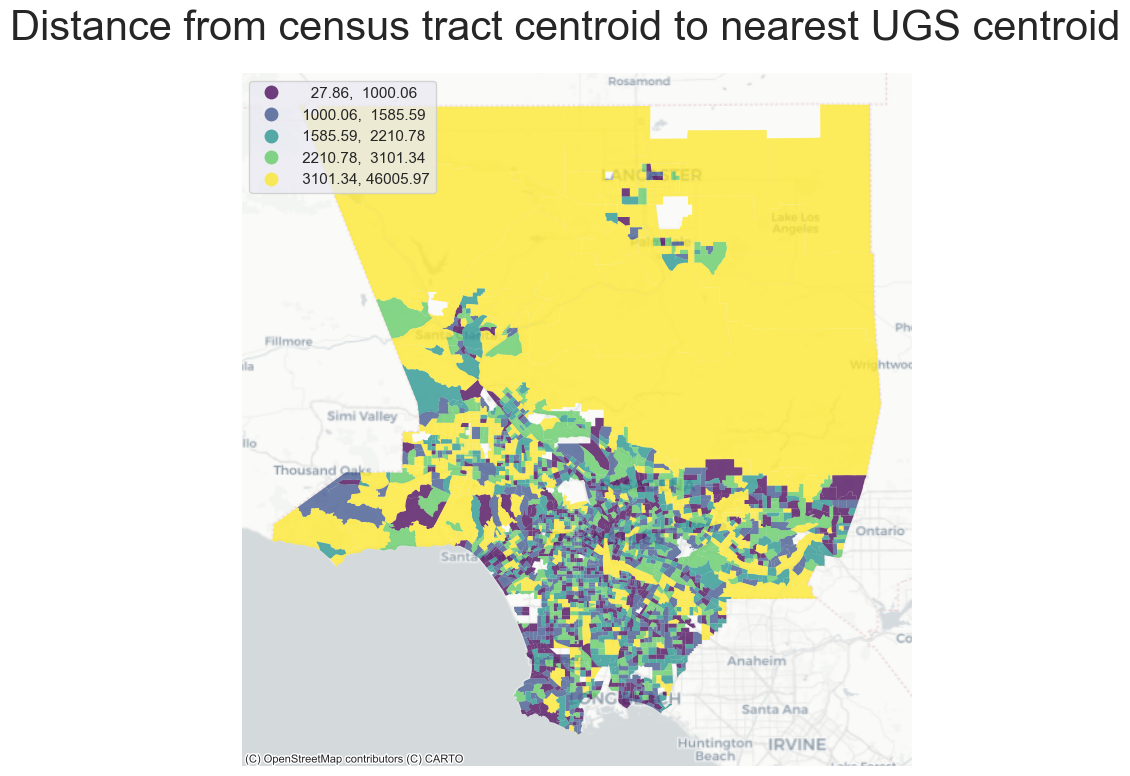

In [595]:
f, ax = plt.subplots(1, figsize=(9, 9))
INCOME_DATA.plot(
    column="min_dist",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=INCOME_DATA.crs,
    source=cx.providers.CartoDB.Positron
)
f.suptitle('Distance from census tract centroid to nearest UGS centroid', size=30, y=0.95)


plt.savefig('min_dist_choro.png', dpi=300, bbox_inches='tight')


ax.set_axis_off()

#### Divide income data into quintiles. 


In [596]:
INCOME_DATA['quantiles_value'] = pd.qcut(INCOME_DATA['med_hh_inc'], 5)
INCOME_DATA['quantiles_name'] = pd.qcut(INCOME_DATA['med_hh_inc'], 5, labels=['very low','low','mid', 'high', 'very high'])
INCOME_DATA['quantiles_name'].value_counts()

quantiles_name
very low     492
very high    492
low          491
mid          491
high         491
Name: count, dtype: int64

#### Find the average minimum distance to green space centroid for each census quantile centroid

In [597]:
average_min_distance = INCOME_DATA.groupby('quantiles_name')['min_dist'].mean()

/var/folders/bl/13rctt8d7y9c04ldf_343xjr0000gn/T/ipykernel_42014/2882515493.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_min_distance = INCOME_DATA.groupby('quantiles_name')['min_dist'].mean()


In [598]:
average_min_distance

quantiles_name
very low     1789.254928
low          2231.629113
mid          2266.656220
high         2378.121838
very high    2551.107349
Name: min_dist, dtype: float64

#### Find the median household income of each quantile

In [599]:
mean_income_by_quantile = INCOME_DATA.groupby('quantiles_name')['med_hh_inc'].mean()
mean_income_by_quantile

/var/folders/bl/13rctt8d7y9c04ldf_343xjr0000gn/T/ipykernel_42014/1506706296.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_income_by_quantile = INCOME_DATA.groupby('quantiles_name')['med_hh_inc'].mean()


quantiles_name
very low      38706.408537
low           54765.276986
mid           69717.042770
high          89202.097760
very high    131818.715447
Name: med_hh_inc, dtype: float64

## What percentage of my census tracts are comprised of green space?

In [600]:
INCOME_DATA['green_area'] = 0.0
INCOME_DATA;

In [601]:
# i = tract (index), tracts = everything else?
# j= index, green_space = 'geometry' column
for i, tracts in INCOME_DATA.iterrows():
    for j, green_space in enumerate(GREEN_DATA['geometry']):
        green_in_tract = tracts['geometry'].intersection(green_space)
        INCOME_DATA.at[i, 'green_area'] += green_in_tract.area

In [602]:
average_green_area = INCOME_DATA.groupby('quantiles_name')['green_area'].mean()
average_green_area

/var/folders/bl/13rctt8d7y9c04ldf_343xjr0000gn/T/ipykernel_42014/2617203466.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_green_area = INCOME_DATA.groupby('quantiles_name')['green_area'].mean()


quantiles_name
very low     8.606538e+05
low          4.695892e+05
mid          7.051363e+06
high         1.481224e+07
very high    5.022249e+07
Name: green_area, dtype: float64

In [603]:
INCOME_DATA.head(5)

tract  med_hh_inc  med_hh_i_1    Shape__Are  \
tract                                                            
06037199700  06037199700     38892.0        1204  1.041050e+07   
06037199801  06037199801     41027.0         903  3.724107e+06   
06037199802  06037199802     42500.0         612  3.296129e+06   
06037199900  06037199900     37232.0         845  4.782361e+06   
06037201110  06037201110     65000.0         782  1.099246e+07   

                                                      geometry  w_med_hh_inc  \
tract                                                                          
06037199700  POLYGON ((6492999.376 1845173.955, 6493667.800...  50484.400000   
06037199801  POLYGON ((6496375.924 1848603.024, 6497557.044...  38093.500000   
06037199802  POLYGON ((6496367.023 1849253.368, 6497136.855...  45232.833333   
06037199900  POLYGON ((6496464.188 1845555.732, 6496410.410...  39088.600000   
06037201110  POLYGON ((6506617.527 1856193.796, 6507052.418...  89542.666667   

             med_hh_inc_std  w_med_hh_inc_std  significant  quadrant  \
tract                                                                  
06037199700       -1.067600         -0.741544         True         3   
06037199801       -1.007549         -1.090059         True         3   
06037199802       -0.966119         -0.889253         True         3   
06037199900       -1.114290         -1.062070         True         3   
06037201110       -0.333267          0.357038        False         2   

                min_dist      quantiles_value quantiles_name     green_area  
tract                                                                        
06037199700  1153.875522  (4917.999, 48261.8]       very low  466471.053409  
06037199801  1601.048157  (4917.999, 48261.8]       very low       0.000000  
06037199802  1439.895091  (4917.999, 48261.8]       very low   69280.821022  
06037199900  2267.023688  (4917.999, 48261.8]       very low   19018.211238  
06037201110   801.010256   (62352.2, 78548.0]            mid  348032.072872

In [604]:
INCOME_DATA['percent_green'] = INCOME_DATA['green_area']/INCOME_DATA['Shape__Are']
INCOME_DATA['percent_green'].head()

tract
06037199700    0.044808
06037199801    0.000000
06037199802    0.021019
06037199900    0.003977
06037201110    0.031661
Name: percent_green, dtype: float64

In [605]:
perc_green_by_quantile = INCOME_DATA.groupby('quantiles_name')['percent_green'].mean()
perc_green_by_quantile

/var/folders/bl/13rctt8d7y9c04ldf_343xjr0000gn/T/ipykernel_42014/3768132554.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perc_green_by_quantile = INCOME_DATA.groupby('quantiles_name')['percent_green'].mean()


quantiles_name
very low     0.018995
low          0.014468
mid          0.024128
high         0.042340
very high    0.089795
Name: percent_green, dtype: float64

/Users/christiancoleturner/Library/Python/3.9/lib/python/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


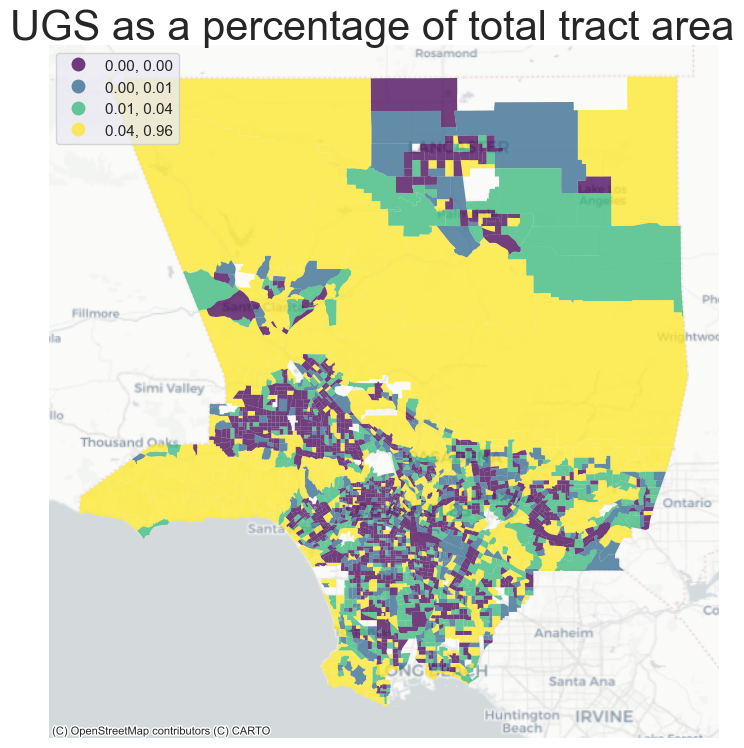

In [606]:
f, ax = plt.subplots(1, figsize=(9, 9))
INCOME_DATA.plot(
    column="percent_green",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=INCOME_DATA.crs,
    source=cx.providers.CartoDB.Positron
)
ax.set_axis_off()

f.suptitle('UGS as a percentage of total tract area', size=30, y=0.92)


plt.savefig('UGS perc.png', dpi=300, bbox_inches='tight')


In [607]:
INCOME_DATA.describe()

med_hh_inc   med_hh_i_1    Shape__Are   w_med_hh_inc  \
count    2457.000000  2457.000000  2.457000e+03    2457.000000   
mean    76848.762719  1354.814815  4.297960e+07   77213.817658   
std     35553.357340   513.678335  4.218258e+08   28701.150564   
min      4918.000000    27.000000  4.836532e+05   20521.333333   
25%     51141.000000  1000.000000  5.876242e+06   54979.833333   
50%     69688.000000  1291.000000  1.014820e+07   72410.285714   
75%     94527.000000  1630.000000  1.793336e+07   92443.800000   
max    250001.000000  5617.000000  1.608691e+10  218750.500000   

       med_hh_inc_std  w_med_hh_inc_std     quadrant      min_dist  \
count    2.457000e+03       2457.000000  2457.000000   2457.000000   
mean    -8.675735e-17          0.010268     2.288970   2243.294327   
std      1.000000e+00          0.807270     1.017924   2209.966360   
min     -2.023178e+00         -1.584307     1.000000     27.864585   
25%     -7.230755e-01         -0.615102     1.000000   1129.096789   
50%     -2.014089e-01         -0.124840     3.000000   1884.944430   
75%      4.972312e-01          0.438638     3.000000   2817.453812   
max      4.870208e+00          3.991233     4.000000  46005.971268   

         green_area  percent_green  
count  2.457000e+03    2457.000000  
mean   1.469210e+07       0.037959  
std    3.480911e+08       0.095264  
min    0.000000e+00       0.000000  
25%    0.000000e+00       0.000000  
50%    1.400091e+04       0.001717  
75%    4.257666e+05       0.031460  
max    1.543202e+10       0.959291

# Autocorrelation of green space % per tract

In [608]:
# Reuse spatial weights from before

## Spatial Lag

In [609]:
INCOME_DATA['w_percent_green'] = weights.lag_spatial(w, INCOME_DATA['percent_green']) # we pass the weights object and the column with values to base the spatial lag on

In [610]:
INCOME_DATA[['tract', 'percent_green', 'w_percent_green']].head()

tract  percent_green  w_percent_green
tract                                                   
06037199700  06037199700       0.044808         0.078309
06037199801  06037199801       0.000000         0.062429
06037199802  06037199802       0.021019         0.049835
06037199900  06037199900       0.003977         0.076235
06037201110  06037201110       0.031661         0.012567

In [611]:
w.neighbors['06037199700']

['06037199001',
 '06037206020',
 '06037199801',
 '06037206010',
 '06037199201',
 '06037199900',
 '06037199002',
 '06037203500',
 '06037980010',
 '06037199802']

In [612]:
# Check the values for neighbors to verify
neig = INCOME_DATA.loc[w.neighbors['06037199700'], 'percent_green']
print(neig)
print('mean:',neig.mean())

tract
06037199001    0.000000
06037206020    0.000000
06037199801    0.000000
06037206010    0.169706
06037199201    0.010378
06037199900    0.003977
06037199002    0.015380
06037203500    0.006576
06037980010    0.556054
06037199802    0.021019
Name: percent_green, dtype: float64
mean: 0.07830893281567289


## Standardize the data

In [613]:
INCOME_DATA['percent_green_std'] = (
    INCOME_DATA['percent_green'] - INCOME_DATA['percent_green'].mean()
) / INCOME_DATA['percent_green'].std()

In [614]:
# Create spatial lag of standardized values
INCOME_DATA['w_percent_green_std'] = weights.lag_spatial(w, INCOME_DATA['percent_green_std'])

In [615]:
INCOME_DATA[['tract', 'percent_green', 'w_percent_green', 'percent_green_std', 'w_percent_green_std']].head()

tract  percent_green  w_percent_green  percent_green_std  \
tract                                                                         
06037199700  06037199700       0.044808         0.078309           0.071897   
06037199801  06037199801       0.000000         0.062429          -0.398459   
06037199802  06037199802       0.021019         0.049835          -0.177820   
06037199900  06037199900       0.003977         0.076235          -0.356715   
06037201110  06037201110       0.031661         0.012567          -0.066108   

             w_percent_green_std  
tract                             
06037199700             0.423565  
06037199801             0.256865  
06037199802             0.124670  
06037199900             0.401791  
06037201110            -0.266538

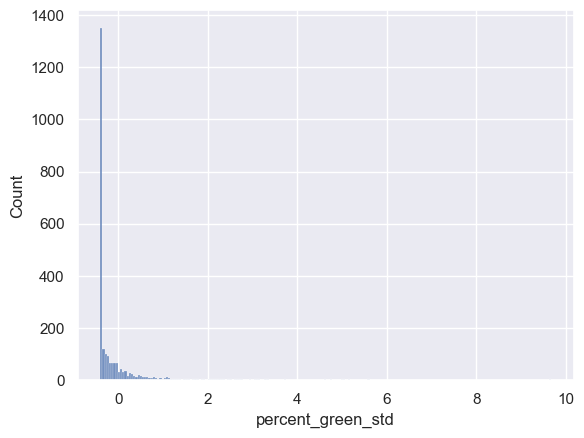

In [616]:
sns.histplot(INCOME_DATA.percent_green_std);

In [617]:
INCOME_DATA['percent_green_std'].describe()

count    2.457000e+03
mean    -6.362206e-17
std      1.000000e+00
min     -3.984594e-01
25%     -3.984594e-01
50%     -3.804362e-01
75%     -6.821563e-02
max      9.671406e+00
Name: percent_green_std, dtype: float64

## Global Spatial Autocorrelation

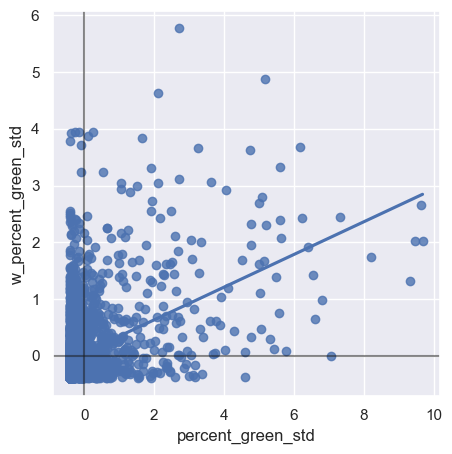

In [618]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='percent_green_std', y='w_percent_green_std', data=INCOME_DATA, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [619]:
mi = esda.Moran(INCOME_DATA['percent_green'], w)

In [620]:
mi.I

0.2883917080867746

In [621]:
mi.p_sim

0.001

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.29)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

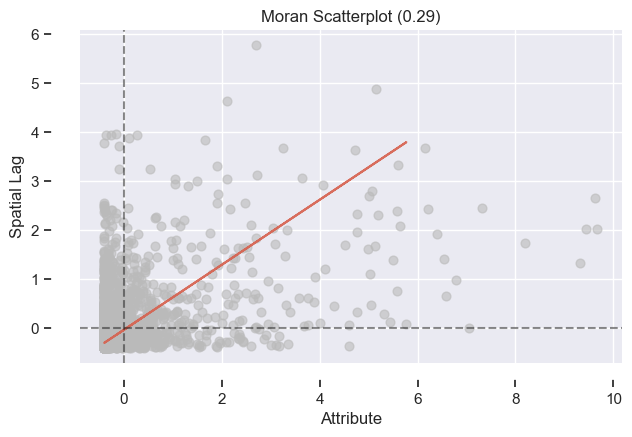

In [622]:
moran_scatterplot(mi)

/Users/christiancoleturner/Library/Python/3.9/lib/python/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.29', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.29)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

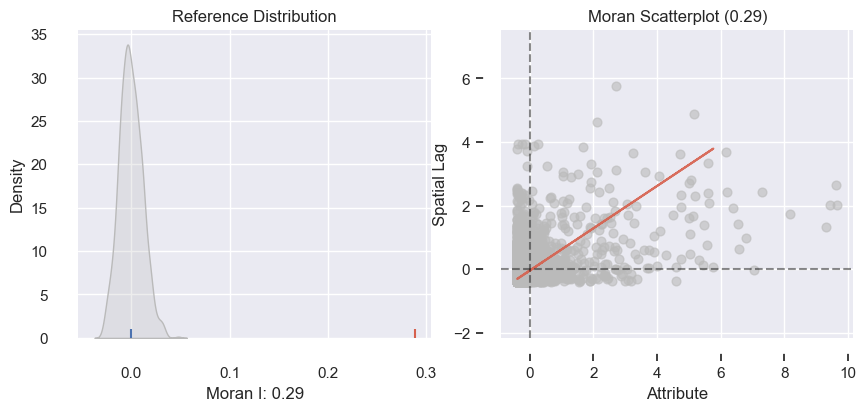

In [623]:
plot_moran(mi)

## LOCAL SPATIAL AUTOCORRELATION

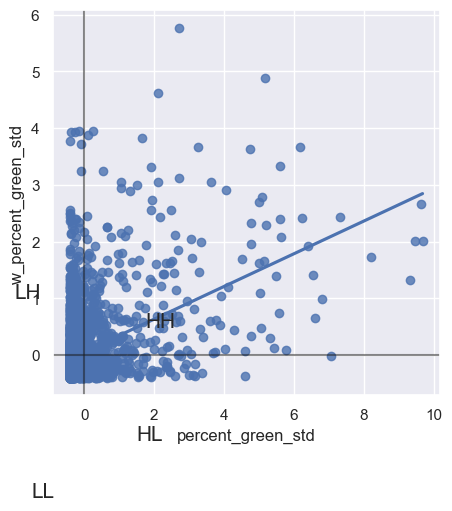

In [624]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='percent_green_std', y='w_percent_green_std', data=INCOME_DATA, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=15)
plt.text(1.5, -1.5, "HL", fontsize=15)
plt.text(-2, 1, "LH", fontsize=15)
plt.text(-1.5, -2.5, "LL", fontsize=15)
# Display
plt.show()

In [625]:
INCOME_DATA['w_percent_green_std'].describe()

count    2457.000000
mean        0.058194
std         0.658870
min        -0.398459
25%        -0.313665
50%        -0.181152
75%         0.120388
max         5.770257
Name: w_percent_green_std, dtype: float64

### LISA


In [626]:
lisa = esda.Moran_Local(INCOME_DATA['percent_green'], w)

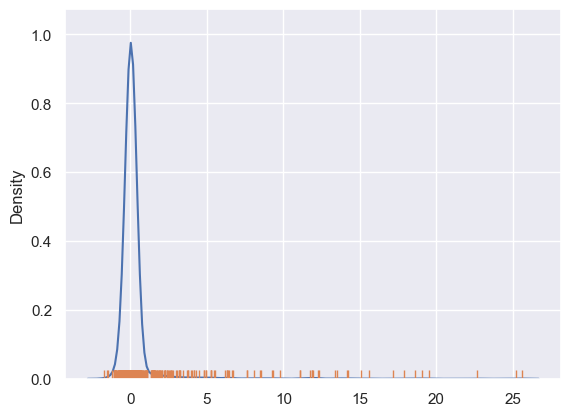

In [627]:
# Draw KDE (kernal density estimation) line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

In [628]:
lisa.Is.sum()

708.2900350611184

In [629]:
mi.I*len(INCOME_DATA)

708.5784267692052

In [630]:
# Break observations into significant or not
INCOME_DATA['green_significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
INCOME_DATA['green_quadrant'] = lisa.q

In [631]:
INCOME_DATA['green_quadrant']

tract
06037199700    1
06037199801    2
06037199802    2
06037199900    2
06037201110    3
              ..
06037554516    2
06037554517    1
06037554518    2
06037554519    1
06037554521    4
Name: green_quadrant, Length: 2457, dtype: int64

In [632]:
INCOME_DATA['green_significant'].describe()

count      2457
unique        2
top       False
freq       1958
Name: green_significant, dtype: object

In [633]:
lisa.p_sim[:5]

array([0.094, 0.198, 0.265, 0.139, 0.262])

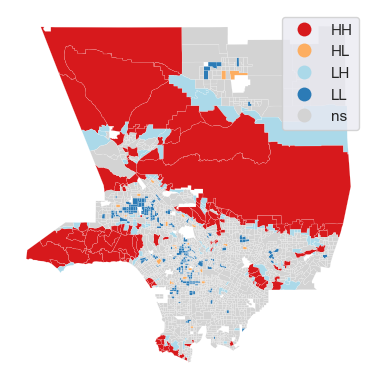

In [634]:
lisa_cluster(lisa, INCOME_DATA, p=0.05); # the vaue for p changes the significance threshold used in the plot

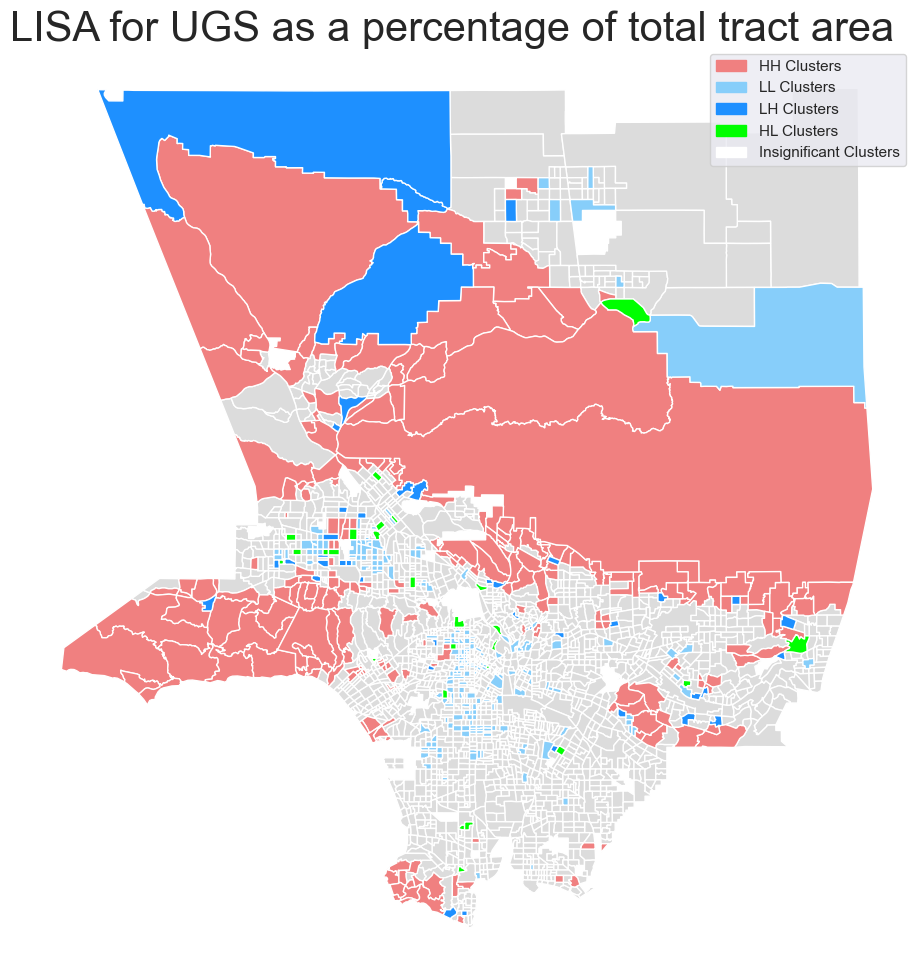

In [635]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Plot insignificant clusters
ns = INCOME_DATA.loc[INCOME_DATA['green_significant']==False, 'geometry']
ns.plot(ax=ax, color='gainsboro', edgecolor = None)
# Plot HH clusters
hh = INCOME_DATA.loc[(INCOME_DATA['quadrant']==1) & (INCOME_DATA['green_significant']==True), 'geometry']
hh.plot(ax=ax, color='lightcoral', edgecolor = None)
# Plot LL clusters
ll = INCOME_DATA.loc[(INCOME_DATA['quadrant']==3) & (INCOME_DATA['green_significant']==True), 'geometry']
ll.plot(ax=ax, color='lightskyblue', edgecolor = None)
# Plot LH clusters
lh = INCOME_DATA.loc[(INCOME_DATA['quadrant']==2) & (INCOME_DATA['green_significant']==True), 'geometry']
lh.plot(ax=ax, color='dodgerblue', edgecolor = None)
# Plot HL clusters
hl = INCOME_DATA.loc[(INCOME_DATA['quadrant']==4) & (INCOME_DATA['green_significant']==True), 'geometry']
hl.plot(ax=ax, color='lime', edgecolor = None)
# Style and draw
f.suptitle('LISA for UGS as a percentage of total tract area', size=30, y=0.91)
f.set_facecolor('white')  # Change the figure face color to white
ax.set_axis_off()




# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='lightcoral', label='HH Clusters'),
    mpatches.Patch(color='lightskyblue', label='LL Clusters'),
    mpatches.Patch(color='dodgerblue', label='LH Clusters'),
    mpatches.Patch(color='lime', label='HL Clusters'),
    mpatches.Patch(color='white', label='Insignificant Clusters')
]
plt.legend(handles=legend_patches, loc='upper right')

plt.savefig('LISA_for_green.png', dpi=300, bbox_inches='tight')


plt.show()

/Users/christiancoleturner/Library/Python/3.9/lib/python/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


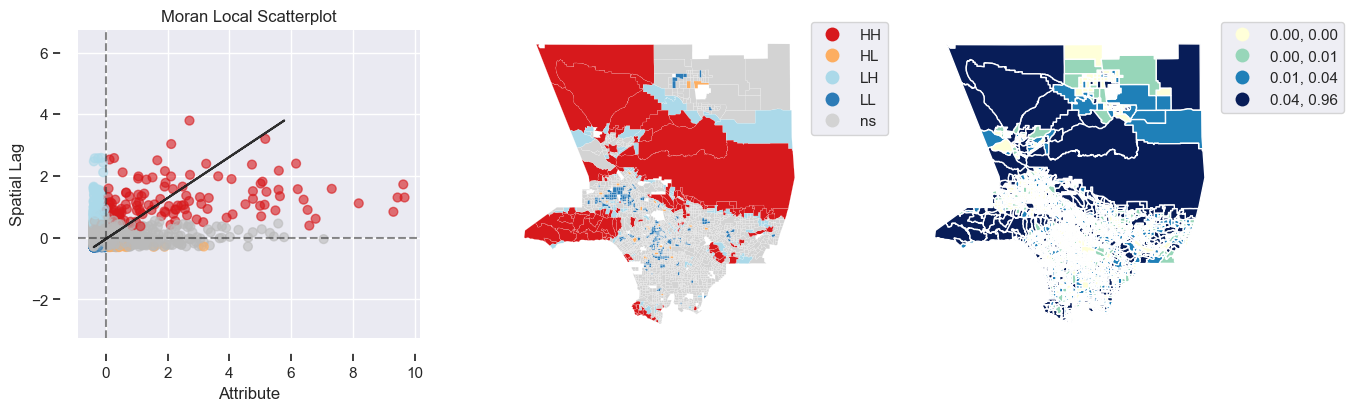

In [636]:
plot_local_autocorrelation(lisa, INCOME_DATA, 'percent_green');

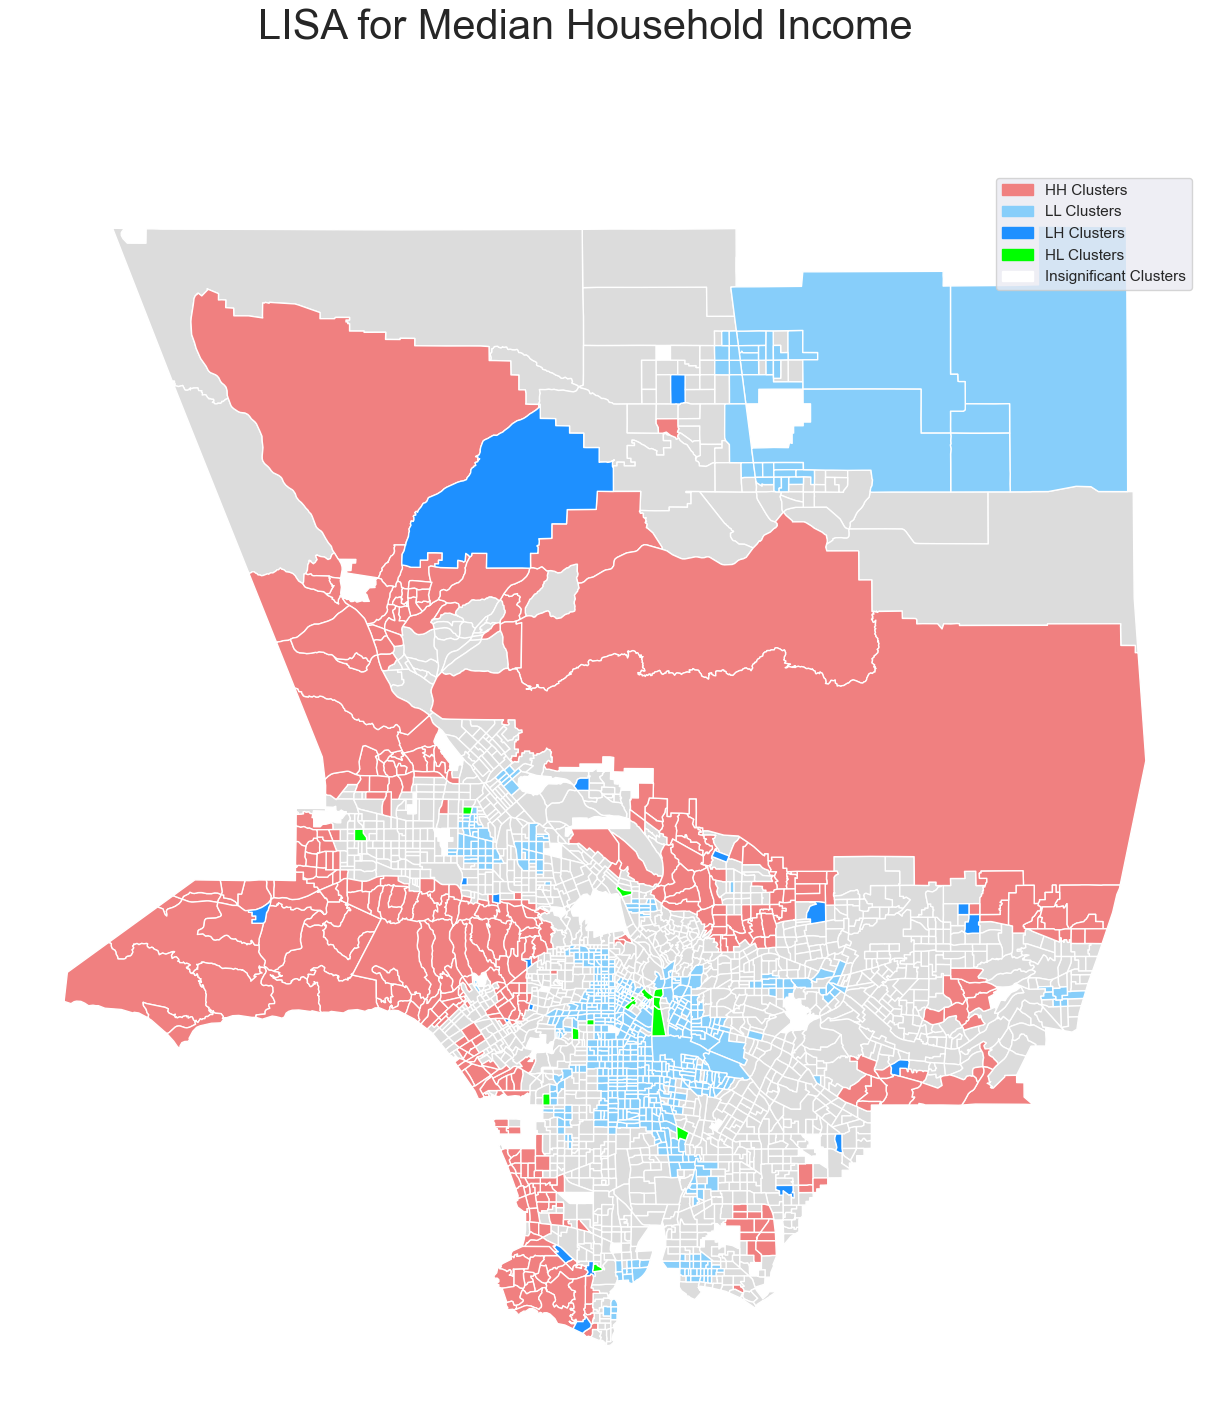

In [637]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(16, 16))
# Plot insignificant clusters
ns = INCOME_DATA.loc[INCOME_DATA['significant']==False, 'geometry']
ns.plot(ax=ax, color='gainsboro', edgecolor = None)
# Plot HH clusters
hh = INCOME_DATA.loc[(INCOME_DATA['quadrant']==1) & (INCOME_DATA['significant']==True), 'geometry']
hh.plot(ax=ax, color='lightcoral', edgecolor = None)
# Plot LL clusters
ll = INCOME_DATA.loc[(INCOME_DATA['quadrant']==3) & (INCOME_DATA['significant']==True), 'geometry']
ll.plot(ax=ax, color='lightskyblue', edgecolor = None)
# Plot LH clusters
lh = INCOME_DATA.loc[(INCOME_DATA['quadrant']==2) & (INCOME_DATA['significant']==True), 'geometry']
lh.plot(ax=ax, color='dodgerblue', edgecolor = None)
# Plot HL clusters
hl = INCOME_DATA.loc[(INCOME_DATA['quadrant']==4) & (INCOME_DATA['significant']==True), 'geometry']
hl.plot(ax=ax, color='lime', edgecolor = None)
# Style and draw
f.suptitle('LISA for Median Household Income', size=30)
f.set_facecolor('white')  # Change the figure face color to white
#f.set_facecolor('0.85')
ax.set_axis_off()



# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='lightcoral', label='HH Clusters'),
    mpatches.Patch(color='lightskyblue', label='LL Clusters'),
    mpatches.Patch(color='dodgerblue', label='LH Clusters'),
    mpatches.Patch(color='lime', label='HL Clusters'),
    mpatches.Patch(color='white', label='Insignificant Clusters')
]
plt.legend(handles=legend_patches, loc='upper right')

plt.savefig('LISA_for_Median_Household_Income.png', dpi=300, bbox_inches='tight')

plt.show()

In [638]:
INCOME_DATA

tract  med_hh_inc  med_hh_i_1    Shape__Are  \
tract                                                            
06037199700  06037199700     38892.0        1204  1.041050e+07   
06037199801  06037199801     41027.0         903  3.724107e+06   
06037199802  06037199802     42500.0         612  3.296129e+06   
06037199900  06037199900     37232.0         845  4.782361e+06   
06037201110  06037201110     65000.0         782  1.099246e+07   
...                  ...         ...         ...           ...   
06037554516  06037554516    126450.0        1215  1.555650e+07   
06037554517  06037554517    107672.0        1352  1.421767e+07   
06037554518  06037554518    104439.0        1558  1.938903e+07   
06037554519  06037554519    131012.0        1216  1.866694e+07   
06037554521  06037554521     90280.0        1863  5.352220e+07   

                                                      geometry   w_med_hh_inc  \
tract                                                                           
06037199700  POLYGON ((6492999.376 1845173.955, 6493667.800...   50484.400000   
06037199801  POLYGON ((6496375.924 1848603.024, 6497557.044...   38093.500000   
06037199802  POLYGON ((6496367.023 1849253.368, 6497136.855...   45232.833333   
06037199900  POLYGON ((6496464.188 1845555.732, 6496410.410...   39088.600000   
06037201110  POLYGON ((6506617.527 1856193.796, 6507052.418...   89542.666667   
...                                                        ...            ...   
06037554516  POLYGON ((6539728.589 1769445.413, 6540269.373...   97793.444444   
06037554517  POLYGON ((6542315.384 1773572.029, 6545420.181...  117648.800000   
06037554518  POLYGON ((6547562.004 1776260.739, 6550203.286...  116284.000000   
06037554519  POLYGON ((6542350.442 1770923.725, 6544981.870...  104377.000000   
06037554521  POLYGON ((6528712.656 1781255.943, 6528802.495...   84606.090909   

             med_hh_inc_std  w_med_hh_inc_std  significant  quadrant  \
tract                                                                  
06037199700       -1.067600         -0.741544         True         3   
06037199801       -1.007549         -1.090059         True         3   
06037199802       -0.966119         -0.889253         True         3   
06037199900       -1.114290         -1.062070         True         3   
06037201110       -0.333267          0.357038        False         2   
...                     ...               ...          ...       ...   
06037554516        1.395121          0.589106        False         1   
06037554517        0.866957          1.147572         True         1   
06037554518        0.776023          1.109185         True         1   
06037554519        1.523435          0.774280        False         1   
06037554521        0.377777          0.218188        False         1   

                min_dist       quantiles_value quantiles_name    green_area  \
tract                                                                         
06037199700  1153.875522   (4917.999, 48261.8]       very low  4.664711e+05   
06037199801  1601.048157   (4917.999, 48261.8]       very low  0.000000e+00   
06037199802  1439.895091   (4917.999, 48261.8]       very low  6.928082e+04   
06037199900  2267.023688   (4917.999, 48261.8]       very low  1.901821e+04   
06037201110   801.010256    (62352.2, 78548.0]            mid  3.480321e+05   
...                  ...                   ...            ...           ...   
06037554516   873.986187  (101131.0, 250001.0]      very high  6.531392e+04   
06037554517  1728.882519  (101131.0, 250001.0]      very high  7.223976e+05   
06037554518  1430.293681  (101131.0, 250001.0]      very high  1.679481e+05   
06037554519  1427.711257  (101131.0, 250001.0]      very high  5.464775e+06   
06037554521  1075.688067   (78548.0, 101131.0]           high  2.671603e+06   

             percent_green  w_percent_green  percent_green_std  \
tract                                                            
060371997

In [639]:
cor_1 = INCOME_DATA[['med_hh_inc', 'min_dist','percent_green', 'Shape__Are']].copy()


In [640]:
cor_1

med_hh_inc     min_dist  percent_green    Shape__Are
tract                                                            
06037199700     38892.0  1153.875522       0.044808  1.041050e+07
06037199801     41027.0  1601.048157       0.000000  3.724107e+06
06037199802     42500.0  1439.895091       0.021019  3.296129e+06
06037199900     37232.0  2267.023688       0.003977  4.782361e+06
06037201110     65000.0   801.010256       0.031661  1.099246e+07
...                 ...          ...            ...           ...
06037554516    126450.0   873.986187       0.004198  1.555650e+07
06037554517    107672.0  1728.882519       0.050810  1.421767e+07
06037554518    104439.0  1430.293681       0.008662  1.938903e+07
06037554519    131012.0  1427.711257       0.292752  1.866694e+07
06037554521     90280.0  1075.688067       0.049916  5.352220e+07

[2457 rows x 4 columns]

In [641]:
pearsoncor = cor_1.corr(method='pearson')
pearsoncor

med_hh_inc  min_dist  percent_green  Shape__Are
med_hh_inc       1.000000  0.096174       0.324146    0.040690
min_dist         0.096174  1.000000       0.132218    0.637011
percent_green    0.324146  0.132218       1.000000    0.325149
Shape__Are       0.040690  0.637011       0.325149    1.000000

In [642]:
pear1

tract
06037199700     38892.0
06037199801     41027.0
06037199802     42500.0
06037199900     37232.0
06037201110     65000.0
                 ...   
06037554516    126450.0
06037554517    107672.0
06037554518    104439.0
06037554519    131012.0
06037554521     90280.0
Name: med_hh_inc, Length: 2457, dtype: float64

In [643]:
from scipy import stats


In [644]:
correlation = stats.pearsonr(cor_1['percent_green'], cor_1['min_dist'])
correlation

PearsonRResult(statistic=0.13221843948371934, pvalue=4.723817551577173e-11)